In [12]:
!pip install flask opencv-python pillow matplotlib seaborn --quiet


In [23]:
app_code = '''
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from flask import Flask, request, jsonify, send_from_directory
from werkzeug.utils import secure_filename

UPLOAD_FOLDER = "uploads"
PLOT_FOLDER = "plots"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(PLOT_FOLDER, exist_ok=True)

app = Flask(__name__)
def _process_image(fpath, class_name, results):
    try:
        img = cv2.imread(fpath)
        if img is None:
            raise Exception("Unreadable")

        h, w, c = img.shape
        results["image_shapes"].append((h, w))
        results["channel_stats"].append(np.mean(img, axis=(0,1)).tolist())
        results["classes"][class_name] += 1
        results["image_count"] += 1

        if len(results["sample_images"]) < 5:
            from PIL import Image
            img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            sample_path = os.path.join(PLOT_FOLDER, f"{class_name}_{os.path.basename(fpath)}")
            img_pil.save(sample_path)
            results["sample_images"].append(f"/plot/{os.path.basename(sample_path)}")

    except:
        results["corrupt_images"].append(os.path.basename(fpath))

def analyze_retina_images_advanced(image_dir):
    results = {
        "image_count": 0,
        "classes": {},
        "image_shapes": [],
        "channel_stats": [],
        "blurriness_scores": [],
        "brightness_levels": [],
        "corrupt_images": [],
        "sample_images": [],
        "plots": []
    }

    sample_mosaic_images = []

    def calculate_blurriness(image):
        return cv2.Laplacian(image, cv2.CV_64F).var()

    def calculate_brightness(image):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        return hsv[:, :, 2].mean()

    def plot_histogram(values, title, xlabel, ylabel, filename):
        plt.figure(figsize=(6,4))
        sns.histplot(values, kde=True)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        path = os.path.join(PLOT_FOLDER, filename)
        plt.savefig(path)
        plt.close()
        return f"/plot/{filename}"

    def plot_mosaic(images, filename, title="Sample Mosaic"):
        n = min(len(images), 9)
        rows = cols = int(np.ceil(np.sqrt(n)))
        fig, axes = plt.subplots(rows, cols, figsize=(10,10))
        for i in range(rows * cols):
            ax = axes[i // cols, i % cols]
            if i < len(images):
                ax.imshow(images[i])
                ax.axis('off')
            else:
                ax.remove()
        plt.suptitle(title)
        path = os.path.join(PLOT_FOLDER, filename)
        plt.savefig(path)
        plt.close()
        return f"/plot/{filename}"

    def process_image(fpath, class_name):
        try:
            img = cv2.imread(fpath)
            if img is None:
                raise Exception("Unreadable")

            h, w, c = img.shape
            results["image_shapes"].append((h, w))
            results["channel_stats"].append(np.mean(img, axis=(0,1)).tolist())
            results["blurriness_scores"].append(calculate_blurriness(img))
            results["brightness_levels"].append(calculate_brightness(img))
            results["classes"].setdefault(class_name, 0)
            results["classes"][class_name] += 1
            results["image_count"] += 1

            if len(results["sample_images"]) < 5:
                from PIL import Image
                img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                sample_path = os.path.join(PLOT_FOLDER, f"{class_name}_{os.path.basename(fpath)}")
                img_pil.save(sample_path)
                results["sample_images"].append(f"/plot/{os.path.basename(sample_path)}")

            if len(sample_mosaic_images) < 9:
                sample_mosaic_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        except:
            results["corrupt_images"].append(os.path.basename(fpath))

    # Detect if dataset is structured (folders) or flat
    has_subfolders = any(
        os.path.isdir(os.path.join(image_dir, f)) for f in os.listdir(image_dir)
    )

    if has_subfolders:
        for class_name in os.listdir(image_dir):
            class_path = os.path.join(image_dir, class_name)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    process_image(os.path.join(class_path, fname), class_name)
    else:
        for fname in os.listdir(image_dir):
            fpath = os.path.join(image_dir, fname)
            if os.path.isfile(fpath):
                process_image(fpath, "Unlabeled")

    # Plots
    results["plots"].append(plot_histogram(
        list(results["classes"].values()), "Class Distribution", "Class", "Count", "class_distribution.png"
    ))

    results["plots"].append(plot_histogram(
        results["blurriness_scores"], "Image Blurriness", "Variance of Laplacian", "Frequency", "blurriness.png"
    ))

    results["plots"].append(plot_histogram(
        results["brightness_levels"], "Image Brightness", "Brightness (HSV V)", "Frequency", "brightness.png"
    ))

    aspect_ratios = [round(w/h, 2) for h, w in results["image_shapes"] if h > 0]
    results["plots"].append(plot_histogram(
        aspect_ratios, "Aspect Ratios", "Width / Height", "Frequency", "aspect_ratios.png"
    ))

    results["plots"].append(plot_mosaic(sample_mosaic_images, "sample_mosaic.png"))

    return results


@app.route("/")
def home():
    return "✅ Retina EDA API is running."

@app.route("/upload", methods=["POST"])
def upload_zip():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    file = request.files["file"]
    zip_path = os.path.join(UPLOAD_FOLDER, secure_filename(file.filename))
    extract_path = os.path.join(UPLOAD_FOLDER, "dataset")
    os.makedirs(extract_path, exist_ok=True)
    file.save(zip_path)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    except Exception as e:
        return jsonify({"error": f"Invalid ZIP: {str(e)}"}), 400

    result = analyze_retina_images_advanced(extract_path)
    return jsonify(result)

@app.route("/plot/<filename>")
def serve_plot(filename):
    return send_from_directory(PLOT_FOLDER, filename)

if __name__ == "__main__":
    app.run(debug=True)

@app.route("/upload_zip", methods=["POST"])
def upload_zip():
    if "file" not in request.files:
        return jsonify({"error": "No file uploaded"}), 400

    file = request.files["file"]
    if not file.filename.endswith(".zip"):
        return jsonify({"error": "Only .zip files are allowed."}), 400

    zip_path = os.path.join(UPLOAD_FOLDER, file.filename)
    extract_path = os.path.join(UPLOAD_FOLDER, "dataset")

    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)  # Remove old extraction
    os.makedirs(extract_path, exist_ok=True)

    file.save(zip_path)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
    except Exception as e:
        return jsonify({"error": f"Failed to unzip: {str(e)}"}), 400

    # This must match where you defined analyze_retina_images_advanced
    from your_analysis_script import analyze_retina_images_advanced
    results = analyze_retina_images_advanced(extract_path)

    return jsonify(results)

'''
with open("app.py", "w") as f:
    f.write(app_code)




In [24]:
requirements = '''
Flask==2.2.5
opencv-python
Pillow
numpy
matplotlib
seaborn
'''
with open("requirements.txt", "w") as f:
    f.write(requirements.strip())


In [25]:
!mkdir -p retina_eda_api/plots
!mkdir -p retina_eda_api/uploads
!mv app.py retina_eda_api/
!mv requirements.txt retina_eda_api/


In [26]:
!zip -r retina_eda_api.zip retina_eda_api/


updating: retina_eda_api/ (stored 0%)
updating: retina_eda_api/app.py (deflated 72%)
updating: retina_eda_api/uploads/ (stored 0%)
updating: retina_eda_api/requirements.txt (stored 0%)
updating: retina_eda_api/plots/ (stored 0%)


In [27]:
from google.colab import files
files.download("retina_eda_api.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Testing the function

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
image_dir="/content/drive/MyDrive/Images"

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def analyze_retina_images_advanced(image_dir):
    results = {
        "image_count": 0,
        "classes": {},
        "image_shapes": [],
        "channel_stats": [],
        "blurriness_scores": [],
        "brightness_levels": [],
        "corrupt_images": [],
        "sample_images": [],
        "sharpest_images": [],
        "blurriest_images": [],
        "plots": [],
        "summary": "",
        "warnings": []
    }

    PLOT_FOLDER = "/content/plots"
    os.makedirs(PLOT_FOLDER, exist_ok=True)

    sample_mosaic_images = []
    class_mean_images = {}
    sharpness_map = {}

    def calculate_blurriness(image):
        return cv2.Laplacian(image, cv2.CV_64F).var()

    def calculate_brightness(image):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        return hsv[:, :, 2].mean()

    def plot_histogram(values, title, xlabel, ylabel, filename):
        plt.figure(figsize=(6, 4))
        sns.histplot(values, kde=True)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        path = os.path.join(PLOT_FOLDER, filename)
        plt.savefig(path)
        plt.close()
        return f"/plot/{filename}"

    def plot_mosaic(images, filename, title="Sample Mosaic"):
        n = min(len(images), 9)
        rows = cols = int(np.ceil(np.sqrt(n)))
        fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
        for i in range(rows * cols):
            ax = axes[i // cols, i % cols]
            if i < len(images):
                ax.imshow(images[i])
                ax.axis('off')
            else:
                ax.remove()
        plt.suptitle(title)
        path = os.path.join(PLOT_FOLDER, filename)
        plt.savefig(path)
        plt.close()
        return f"/plot/{filename}"

    def detect_outliers(values, title, filename):
        q1 = np.percentile(values, 25)
        q3 = np.percentile(values, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = [v for v in values if v < lower_bound or v > upper_bound]

        plt.figure(figsize=(6, 4))
        sns.boxplot(x=values)
        plt.title(f"Outlier Detection: {title}")
        path = os.path.join(PLOT_FOLDER, filename)
        plt.savefig(path)
        plt.close()
        return f"/plot/{filename}", outliers

    def process_image(fpath, class_name):
        try:
            img = cv2.imread(fpath)
            if img is None:
                raise Exception("Unreadable")

            h, w, c = img.shape
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            results["image_shapes"].append((h, w))
            results["channel_stats"].append(np.mean(img_rgb, axis=(0, 1)).tolist())

            blur = calculate_blurriness(img)
            bright = calculate_brightness(img)
            results["blurriness_scores"].append(blur)
            results["brightness_levels"].append(bright)

            results["classes"].setdefault(class_name, 0)
            results["classes"][class_name] += 1
            results["image_count"] += 1
            sharpness_map[fpath] = blur

            class_mean_images.setdefault(class_name, []).append(img_rgb / 255.0)

            if len(results["sample_images"]) < 5:
                img_pil = Image.fromarray(img_rgb)
                sample_path = os.path.join(PLOT_FOLDER, f"{class_name}_{os.path.basename(fpath)}")
                img_pil.save(sample_path)
                results["sample_images"].append(f"/plot/{os.path.basename(sample_path)}")

            if len(sample_mosaic_images) < 9:
                sample_mosaic_images.append(img_rgb)

        except Exception as e:
            results["corrupt_images"].append(os.path.basename(fpath))

    # Dataset reading
    has_subfolders = any(os.path.isdir(os.path.join(image_dir, f)) for f in os.listdir(image_dir))

    if has_subfolders:
        for class_name in os.listdir(image_dir):
            class_path = os.path.join(image_dir, class_name)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    process_image(os.path.join(class_path, fname), class_name)
    else:
        for fname in os.listdir(image_dir):
            fpath = os.path.join(image_dir, fname)
            if os.path.isfile(fpath):
                process_image(fpath, "Unlabeled")

    # Sharpness ranking
    sorted_blur = sorted(sharpness_map.items(), key=lambda x: x[1])
    results["blurriest_images"] = [os.path.basename(x[0]) for x in sorted_blur[:3]]
    results["sharpest_images"] = [os.path.basename(x[0]) for x in sorted_blur[-3:]]

    # Mean image per class
    for cls, imgs in class_mean_images.items():
        mean_img = np.clip(np.mean(imgs, axis=0) * 255, 0, 255).astype(np.uint8)
        mean_path = os.path.join(PLOT_FOLDER, f"mean_{cls}.png")
        Image.fromarray(mean_img).save(mean_path)
        results["plots"].append(f"/plot/{os.path.basename(mean_path)}")

    # PCA and t-SNE plots
    if len(results["channel_stats"]) > 5:
        X = np.array(results["channel_stats"])

        pca = PCA(n_components=2)
        pca_proj = pca.fit_transform(X)
        plt.figure(figsize=(6, 5))
        plt.scatter(pca_proj[:, 0], pca_proj[:, 1], alpha=0.7)
        plt.title("PCA of Color Statistics")
        path_pca = os.path.join(PLOT_FOLDER, "pca_plot.png")
        plt.savefig(path_pca)
        plt.close()
        results["plots"].append(f"/plot/{os.path.basename(path_pca)}")

        tsne = TSNE(n_components=2, random_state=42, perplexity=5)
        tsne_proj = tsne.fit_transform(X)
        plt.figure(figsize=(6, 5))
        plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], alpha=0.7)
        plt.title("t-SNE of Color Statistics")
        path_tsne = os.path.join(PLOT_FOLDER, "tsne_plot.png")
        plt.savefig(path_tsne)
        plt.close()
        results["plots"].append(f"/plot/{os.path.basename(path_tsne)}")

    # Regular plots
    results["plots"].append(plot_histogram(list(results["classes"].values()), "Class Distribution", "Class", "Count", "class_distribution.png"))
    results["plots"].append(plot_histogram(results["blurriness_scores"], "Image Blurriness", "Variance of Laplacian", "Frequency", "blurriness.png"))
    results["plots"].append(plot_histogram(results["brightness_levels"], "Image Brightness", "Brightness (HSV V)", "Frequency", "brightness.png"))

    aspect_ratios = [round(w / h, 2) for h, w in results["image_shapes"] if h > 0]
    results["plots"].append(plot_histogram(aspect_ratios, "Aspect Ratios", "Width / Height", "Frequency", "aspect_ratios.png"))

    results["plots"].append(plot_mosaic(sample_mosaic_images, "sample_mosaic.png"))

    # Outlier detection
    outlier_plot_bright, outliers_bright = detect_outliers(results["brightness_levels"], "Brightness", "brightness_outliers.png")
    outlier_plot_blurry, outliers_blurry = detect_outliers(results["blurriness_scores"], "Blurriness", "blurriness_outliers.png")
    results["plots"].append(outlier_plot_bright)
    results["plots"].append(outlier_plot_blurry)

    # Summary and warnings
    avg_brightness = round(np.mean(results["brightness_levels"]), 2)
    avg_blur = round(np.mean(results["blurriness_scores"]), 2)
    blurry_percentage = sum(b < 100 for b in results["blurriness_scores"]) / len(results["blurriness_scores"]) * 100

    summary_lines = [
        f"Total images analyzed: {results['image_count']}",
        f"Average brightness: {avg_brightness}",
        f"Average sharpness (Laplacian variance): {avg_blur}",
        f"Top 3 sharpest images: {results['sharpest_images']}",
        f"Top 3 blurriest images: {results['blurriest_images']}",
        f"Images too blurry (<100 variance): {blurry_percentage:.2f}%",
        f"Detected {len(outliers_bright)} brightness outliers, {len(outliers_blurry)} blurriness outliers."
    ]

    if blurry_percentage > 20:
        results["warnings"].append("\u26a0\ufe0f High proportion of blurry images detected.")

    results["summary"] = "\n".join(summary_lines)

    return results


In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Required folders
PLOT_FOLDER = "/content/plots"
UPLOAD_FOLDER = "/content/uploads"
os.makedirs(PLOT_FOLDER, exist_ok=True)
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# Point to your Drive folder with only retina images (flat, no subfolders)
image_dir = "/content/drive/MyDrive/Images"


In [21]:
results = analyze_retina_images_advanced(image_dir)


Total Images: 20
Classes: {'Unlabeled': 20}
Corrupt Files: []


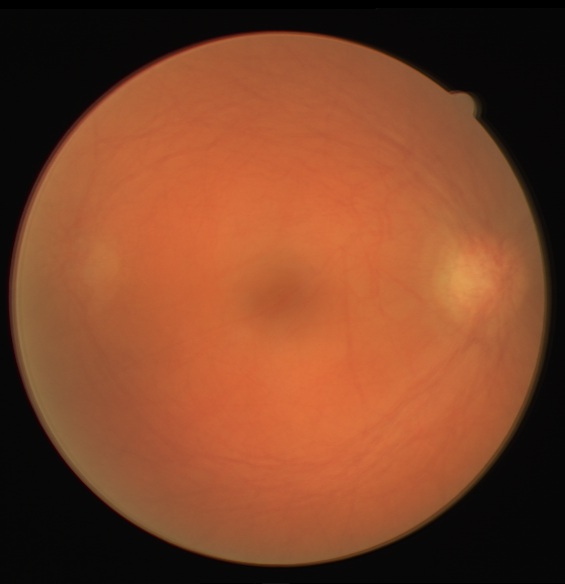

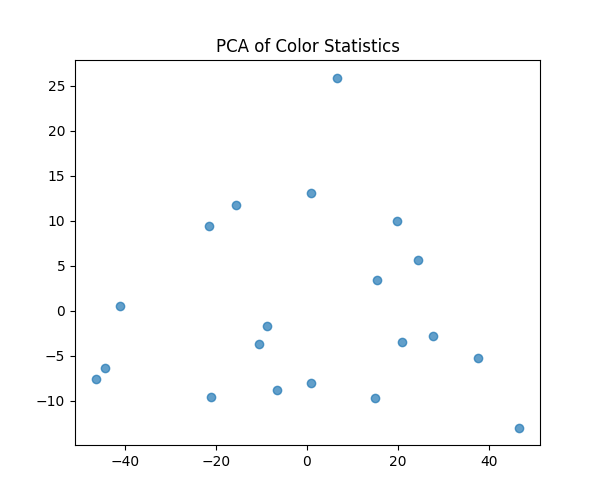

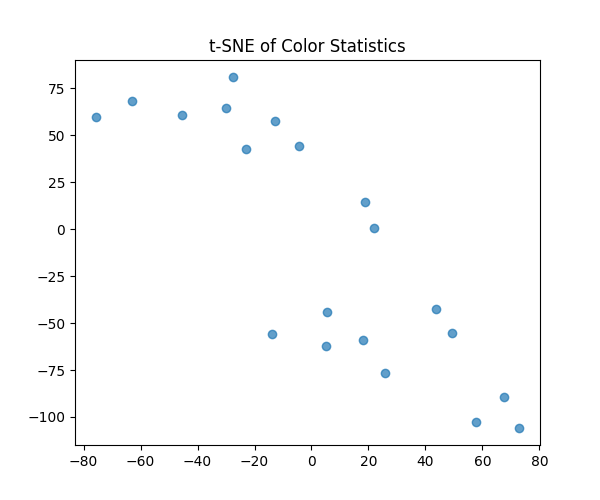

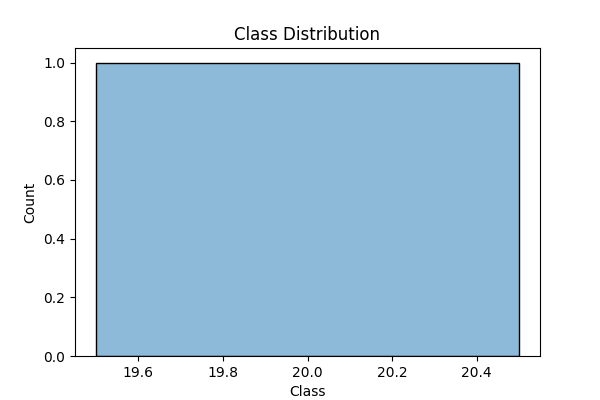

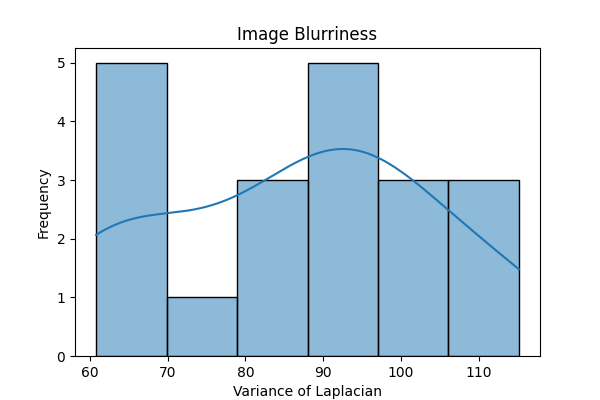

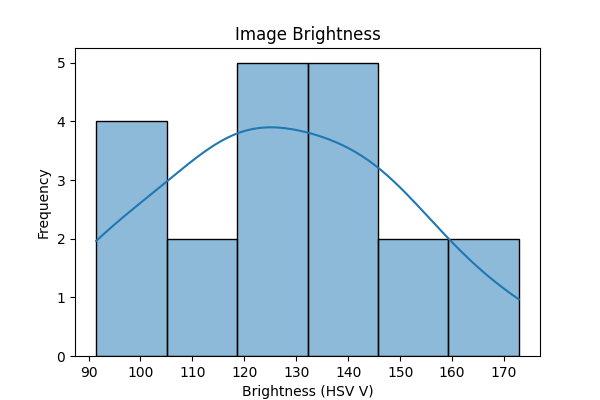

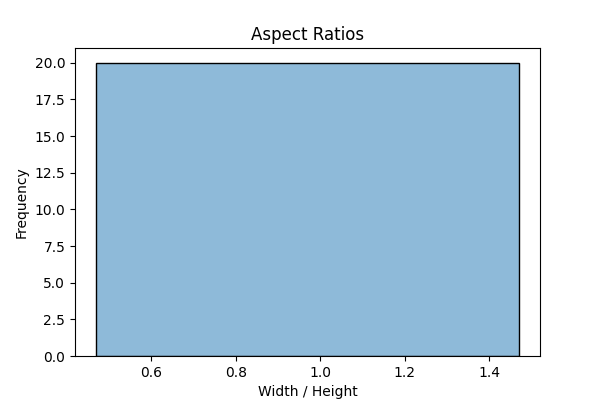

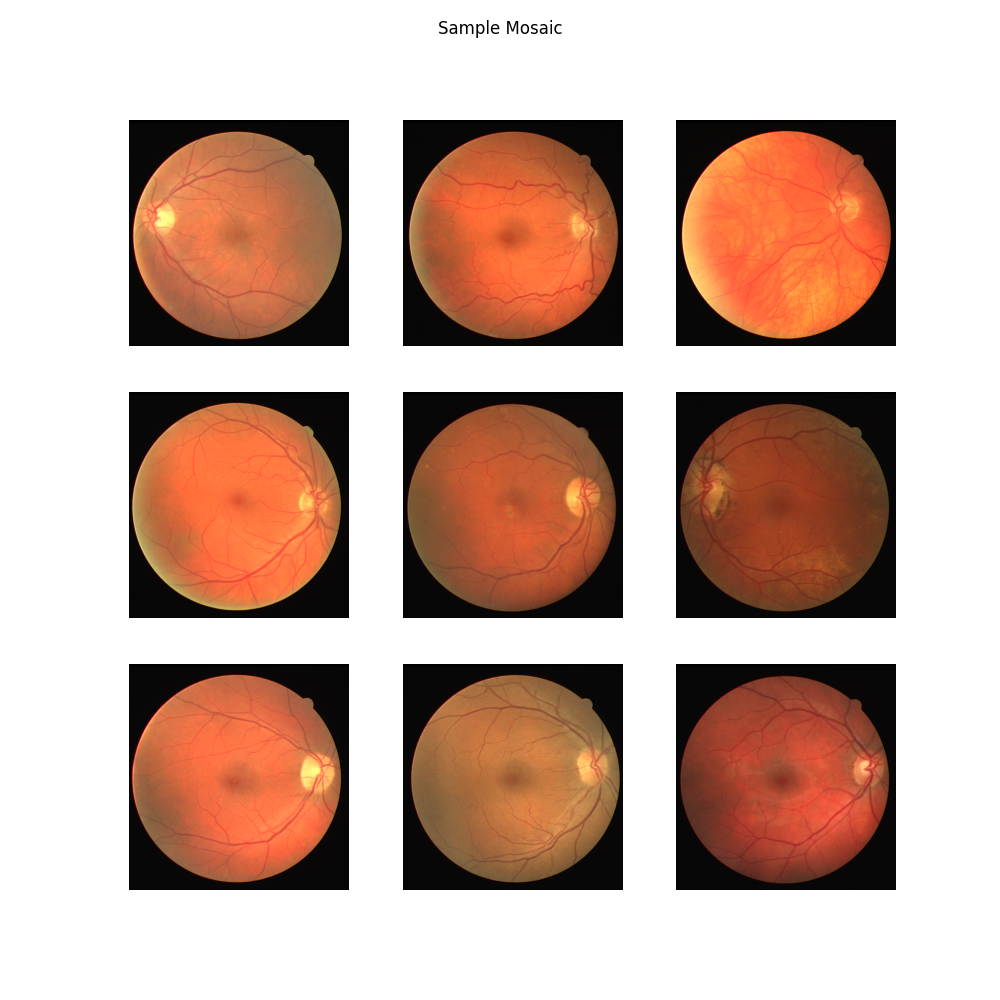

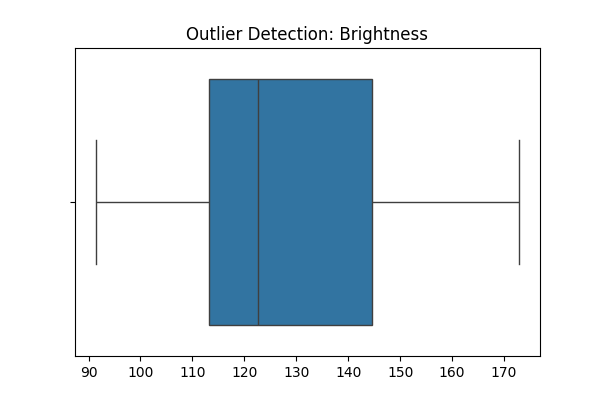

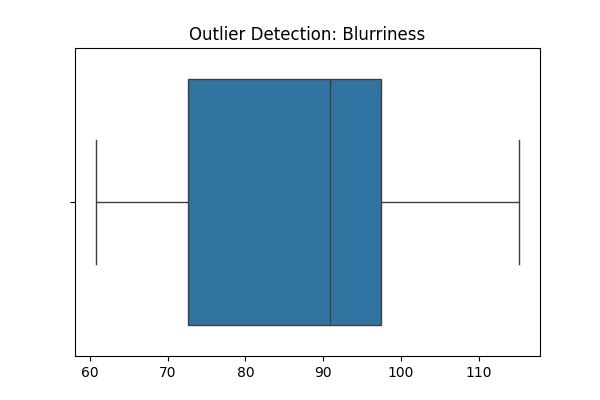

In [22]:
from IPython.display import Image, display

# Print summary
print("Total Images:", results["image_count"])
print("Classes:", results["classes"])
print("Corrupt Files:", results["corrupt_images"])

# Show all generated plots
for plot_path in results["plots"]:
    local_path = os.path.join("plots", os.path.basename(plot_path))
    display(Image(filename=local_path))
